In [1]:
!pip install sphfile

  Created wheel for sphfile: filename=sphfile-1.0.3-cp36-none-any.whl size=4153 sha256=97c0f9e81350e9f2d493365e6414882e8ea52d4c036b1f9191a798fdcffe993e
  Stored in directory: /root/.cache/pip/wheels/84/f4/18/48665f3dc6b6cba45408f3afa7f6bbd15209325b50f713ff11
Successfully built sphfile


In [2]:
import numpy as np
import tensorflow
import scipy.io.wavfile
import scipy.signal
import os
import matplotlib.pyplot as plt
import random
import librosa
import IPython.display as ipd

In [3]:
cwd = "/content/drive/My Drive/timit"
print(cwd)

/content/drive/My Drive/timit


In [4]:
from pathlib import Path 
from sphfile import SPHFile 

In [5]:
soundClips = []
for soundFile in Path(cwd).glob('**/*.wav'):
    soundClips += [scipy.io.wavfile.read(soundFile)] 
dataRate = soundClips[0][0] 
soundClips = [i[1] for i in soundClips] 

In [6]:
soundClips

[array([1, 3, 4, ..., 4, 2, 6], dtype=int16),
 array([-1,  1,  3, ...,  2,  1, -3], dtype=int16),
 array([ -9, -12, -11, ...,   6,   2,   6], dtype=int16),
 array([ 4,  1, -2, ...,  3,  1, -3], dtype=int16),
 array([-1,  3,  3, ..., -1,  0, -1], dtype=int16),
 array([4, 2, 1, ..., 1, 4, 2], dtype=int16),
 array([ -5, -18, -22, ...,   2,   3,   2], dtype=int16),
 array([ 0,  3,  6, ..., -4, -3, -2], dtype=int16),
 array([-1,  2,  5, ...,  6,  2,  2], dtype=int16),
 array([13, 11,  6, ...,  4, -1,  4], dtype=int16),
 array([10, 10, 19, ..., -1,  1,  1], dtype=int16),
 array([-13,   4,   6, ...,  -2,   1,  -1], dtype=int16),
 array([ 7, -4,  3, ..., -5,  7,  0], dtype=int16),
 array([-2, -5, -2, ...,  1,  8, -5], dtype=int16),
 array([-10,   1,  -8, ...,   6,   6,   1], dtype=int16),
 array([-28, -17, -10, ...,  -1,  -2,  -3], dtype=int16),
 array([ 1,  1, -2, ...,  1, -2, -1], dtype=int16),
 array([19, 11, 13, ..., -2,  4, -5], dtype=int16),
 array([19, -4,  2, ...,  6, -4,  1], dtype=in

In [7]:
len(soundClips)

160

In [8]:
mergedSpeech = np.concatenate(soundClips, axis=0)
"""
concatenate example
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6]])
np.concatenate((a, b), axis=0)
array([[1, 2],
       [3, 4],
       [5, 6]])"""
validationSpeech = mergedSpeech[mergedSpeech.shape[0] * 9 // 10:] 
mergedSpeech = mergedSpeech[:mergedSpeech.shape[0] * 9 // 10] 
normalizingFactor=np.std(mergedSpeech)

In [9]:
soundClips[1].shape

(45671,)

In [50]:
mergedSpeech.shape[0]-(7057393*9//10)

705740

In [10]:
noisingFactor=.15
clipLength = 1024
mergedSpeech.shape

(7057393,)

In [11]:
mergedSpeech

array([ 1,  3,  4, ...,  3, -3, -9], dtype=int16)

In [12]:

def stackLayers(layerSet):
    stack = layerSet[0]
    for i in range(1, len(layerSet)):
        stack = layerSet[i](stack)
    return stack

In [13]:
denoiserLayers = [
    tensorflow.keras.layers.Input(shape=(clipLength,)),
    tensorflow.keras.layers.Reshape((clipLength, 1)),

    tensorflow.keras.layers.Conv1D(filters=64, kernel_size=25, padding='same'),
    tensorflow.keras.layers.LeakyReLU(),
    tensorflow.keras.layers.Conv1D(filters=64, kernel_size=25, padding='same'),
    tensorflow.keras.layers.LeakyReLU(),
    tensorflow.keras.layers.Dropout(.4),

    tensorflow.keras.layers.Conv1D(filters=64, kernel_size=25, padding='same'),
    tensorflow.keras.layers.LeakyReLU(),
    tensorflow.keras.layers.Conv1D(filters=64, kernel_size=25, padding='same'),
    tensorflow.keras.layers.LeakyReLU(),
    tensorflow.keras.layers.Dropout(.4),

    tensorflow.keras.layers.Conv1D(filters=64, kernel_size=25, padding='same'),
    tensorflow.keras.layers.LeakyReLU(),
    tensorflow.keras.layers.Conv1D(filters=64, kernel_size=25, padding='same'),
    tensorflow.keras.layers.LeakyReLU(),
    tensorflow.keras.layers.Dropout(.4),

    tensorflow.keras.layers.Conv1D(filters=64, kernel_size=25, padding='same'),
    tensorflow.keras.layers.LeakyReLU(),

    tensorflow.keras.layers.Conv1D(filters=1, kernel_size=25, padding='same'),
    tensorflow.keras.layers.Dropout(.4),

    tensorflow.keras.layers.Reshape((clipLength,)),
]

In [14]:

def sampleGenerator(originalSound, sampleLength, noisingFactor, batchSize=32, firstFixed=None):
    while 1:
        indices = np.random.randint(low=0, high=originalSound.shape[0] - sampleLength, size=batchSize).tolist()
        if firstFixed != None:
            indices[0] = firstFixed
        samples = np.array([originalSound[index:index + sampleLength] for index in indices])
        noise = np.random.normal(loc=0, scale=2*random.random()*noisingFactor*normalizingFactor, size=samples.shape)
        #print (samples.shape)
        yield ((samples+noise)/normalizingFactor,samples/normalizingFactor)

In [15]:
clipGenerator = sampleGenerator(mergedSpeech, clipLength, noisingFactor, 32)
validationClipGenerator = sampleGenerator(validationSpeech, clipLength, noisingFactor, 256)
denoiser = tensorflow.keras.models.Model(inputs=denoiserLayers[0], outputs=stackLayers(denoiserLayers))
denoiser.compile(optimizer=tensorflow.keras.optimizers.Adam(.0001, decay=1e-7), loss='mse', metrics=['mse', ])
denoiser.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
reshape (Reshape)            (None, 1024, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1024, 64)          1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1024, 64)          102464    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1024, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1024, 64)          0     

In [16]:
denoiser.fit(clipGenerator, steps_per_epoch=512, epochs=10, validation_data=validationClipGenerator,
                       validation_steps=16, use_multiprocessing=True,
                       verbose=1)

Epoch 1/10
512/512 [==============================] - 17s 34ms/step - loss: 0.4396 - mse: 0.4396 - val_loss: 0.5194 - val_mse: 0.5194
Epoch 2/10
512/512 [==============================] - 17s 33ms/step - loss: 0.4251 - mse: 0.4251 - val_loss: 0.5022 - val_mse: 0.5022
Epoch 3/10
512/512 [==============================] - 17s 34ms/step - loss: 0.4227 - mse: 0.4227 - val_loss: 0.4909 - val_mse: 0.4909
Epoch 4/10
512/512 [==============================] - 18s 35ms/step - loss: 0.4052 - mse: 0.4052 - val_loss: 0.4954 - val_mse: 0.4954
Epoch 5/10
512/512 [==============================] - 18s 35ms/step - loss: 0.4121 - mse: 0.4121 - val_loss: 0.4157 - val_mse: 0.4157
Epoch 6/10
512/512 [==============================] - 18s 36ms/step - loss: 0.4230 - mse: 0.4230 - val_loss: 0.4640 - val_mse: 0.4640
Epoch 7/10
512/512 [==============================] - 18s 36ms/step - loss: 0.4109 - mse: 0.4109 - val_loss: 0.4867 - val_mse: 0.4867
Epoch 8/10
512/512 [==============================] - 18s 35ms

In [17]:
def sequentialPredict(data, subsequenceLength, stride): 
    assert stride <= subsequenceLength
    batchSize = 32
    batchedData = np.empty((int(np.ceil(data.shape[0] - subsequenceLength) / stride) + 1, subsequenceLength))
    startIndices=np.empty((batchedData.shape[0],),dtype=np.int32)
    for i in range(0, batchedData.shape[0]):
        startIndex = i*stride
        if startIndex > data.shape[0] - subsequenceLength:
            startIndex = data.shape[0] - subsequenceLength
        startIndex=int(startIndex)
        batchedData[i] = data[startIndex:startIndex + subsequenceLength] / normalizingFactor
        startIndices[i]=startIndex
    processedBatches = denoiser.predict(batchedData,batch_size=batchSize)*normalizingFactor

    finalData = np.zeros(data.shape)
    hitCounter = np.zeros(data.shape)
    for i in range (0,batchedData.shape[0]):
        finalData[startIndices[i]:startIndices[i]+subsequenceLength]+=processedBatches[i]
        hitCounter[startIndices[i]:startIndices[i]+subsequenceLength]+=1
    finalData=np.divide(finalData,hitCounter)
    return finalData.astype(np.int16)

Predicting for first clip in the data set

In [18]:
clip = soundClips[0]
noisedClip = (clip + np.random.normal(loc=0, scale=noisingFactor*normalizingFactor, size=clip.shape)).astype(np.int16)

In [19]:
predicted = sequentialPredict(noisedClip, clipLength, stride=clipLength//2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


In [20]:
scipy.io.wavfile.write("predicted.wav", dataRate, predicted)
scipy.io.wavfile.write("original.wav", dataRate, soundClips[0])
scipy.io.wavfile.write("noised.wav", dataRate, noisedClip)

width = 1000
baseIndex = 20000

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


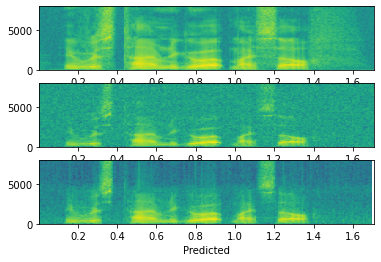

In [21]:
plt.subplot(311)
plt.specgram(soundClips[0], Fs=dataRate)
plt.xlabel("Original")

plt.subplot(312)
plt.specgram(noisedClip, Fs=dataRate)
plt.xlabel("Noised")

plt.subplot(313)
plt.specgram(predicted, Fs=dataRate)
plt.xlabel("Predicted")

plt.show()

In [22]:
print("Original")
ipd.Audio('/content/original.wav')

Original


In [23]:
print("noised")
ipd.Audio('/content/noised.wav')

noised


In [24]:
print("noise_removed")
ipd.Audio('/content/predicted.wav')

noise_removed


predicting 16 th clip in the data set

In [25]:
clip = soundClips[15]
noisedClip = (clip + np.random.normal(loc=0, scale=noisingFactor*normalizingFactor, size=clip.shape)).astype(np.int16)

In [26]:
predicted = sequentialPredict(noisedClip, clipLength, stride=clipLength//2)


In [40]:
dataRate=16000
sr=8000

In [41]:
scipy.io.wavfile.write("predicted3.wav", dataRate, predicted)
scipy.io.wavfile.write("original3.wav", dataRate, soundClips[15])
scipy.io.wavfile.write("noised3.wav", dataRate, noisedClip)
# save it as 8khz samples signal
y, s = librosa.load('predicted3.wav', sr=8000)
librosa.output.write_wav('predicted3_8khz.wav', y, sr)
y, s = librosa.load('original3.wav', sr=8000)
librosa.output.write_wav('original3_8khz.wav', y, sr)
y, s = librosa.load('noised3.wav', sr=8000)
librosa.output.write_wav('noised3_8khz.wav', y, sr)

width = 1000
baseIndex = 20000

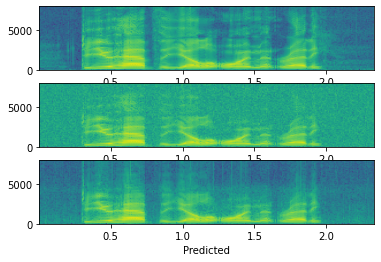

In [42]:
plt.subplot(311)
plt.specgram(soundClips[15], Fs=dataRate)
plt.xlabel("Original")

plt.subplot(312)
plt.specgram(noisedClip, Fs=dataRate)
plt.xlabel("Noised")

plt.subplot(313)
plt.specgram(predicted, Fs=dataRate)
plt.xlabel("Predicted")

plt.show()

In [43]:
print("Original")
ipd.Audio('/content/original3.wav')

Original


In [44]:
print("noised")
ipd.Audio('/content/noised3.wav')

noised


In [45]:
print("noise_removed")
ipd.Audio('/content/predicted3.wav')

noise_removed


In [46]:
print("Original")
ipd.Audio('/content/original3_8khz.wav')

Original


In [47]:
print("noised")
ipd.Audio('/content/noised3_8khz.wav')

noised


In [48]:
print("noise_removed")
ipd.Audio('/content/predicted3_8khz.wav')

noise_removed
